# Urban Sound RNN Classification

### Introduction

This Jupyter notebook was created by Filipe Barros, Gonçalo Arrobas and João Barão for the Machine Learning II.

### Authorship

Author: Filipe Barros, Gonçalo Arrobas and João Barão
University: Faculty of Science from University of Porto
Course: Machine Learning II
Sound Classification Problem

For this project, the students were tasked with the development of a deed learning model for audio classification. The data from the UrbanSound8K dataset was used throughout the development of this project. This dataset contains a total of 8732 labeled audio recordings of urban sounds, each with a duration of up to four seconds. Each excerpts has been labeled with one of the following classes:

0 = air_conditioner

1 = car_horn

2 = children_playing

3 = dog_bark

4 = drilling

5 = engine_idling

6 = gun_shot

7 = jackhammer

8 = siren

9 = street_music

The objective of this project relies on defining, compiling, training and evaluating two Deep Learning (DL) classifiers. The DL model types to be considered are:

Multilayer Perceptron (MLP)
Convolutional Neural Network (rnn)
Recurrent Neural Network (RNN)

### Import Statements

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, Bidirectional, Conv2D, MaxPooling2D, GlobalAveragePooling2D, SpatialDropout2D, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
import keras.backend
import matplotlib.image as mpimg
from keras_tuner.tuners import Hyperband
from keras.backend import clear_session


### Data Analysis

In [2]:
print("Loading CSV file {}".format('UrbanSound8K.csv'))

# Load metadata as a Pandas dataframe
metadata = pd.read_csv('UrbanSound8K.csv')

# Examine dataframe's head
metadata.head()

Loading CSV file UrbanSound8K.csv


,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


#### Class Distribution

In [3]:
metadata['class'].value_counts()

class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
jackhammer          1000
engine_idling       1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64

### Feature Engineering

In [4]:
# Inicializar listas vazias para carregar os dados
X_folds = []
y_folds = []
X_folds_aug = []
y_folds_aug = []

le = LabelEncoder()

# Carregar e plotar cada fold
for i in range(10):
    X_fold_aug = np.load(f'fold{i + 1}_features_augmented.npy', allow_pickle=True)
    y_fold_aug = np.load(f'fold{i + 1}_labels_augmented.npy', allow_pickle=True)
    X_fold = np.load(f'fold{i + 1}features.npy', allow_pickle=True)
    y_fold = np.load(f'fold{i + 1}labels.npy', allow_pickle=True)

    scalers = {}
    scalers_aug = {}
    for i in range(X_fold.shape[1]):
        scalers[i] = StandardScaler()
        X_fold[:, i, :] = scalers[i].fit_transform(X_fold[:, i, :])
    for i in range(X_fold_aug.shape[1]):
        scalers_aug[i] = StandardScaler()
        X_fold_aug[:, i, :] = scalers_aug[i].fit_transform(X_fold_aug[:, i, :])
    y_fold = to_categorical(le.fit_transform(y_fold))
    y_fold_aug = to_categorical(le.fit_transform(y_fold_aug))

    X_folds.append(X_fold)
    y_folds.append(y_fold)
    X_folds_aug.append(X_fold_aug)
    y_folds_aug.append(y_fold_aug)

### Model Architecture

#### Long-Short Term Memory (LSTM) 


In [5]:
def create_bidirectional_lstm_model(input_shape=(40,174), units=64, dropout_rate=0.2, l2_reg=0.000125567917146748):
    model = Sequential()
    
    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # First Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    model.compile(optimizer=Adam(learning_rate=0.00011908740025576155), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [6]:
def create_unidirectional_lstm_model(input_shape=(40, 174), units=64, dropout_rate=0.2, l2_reg=0.000125567917146748):
    model = Sequential()
    
    # First unidirectional LSTM layer with L2 regularization
    model.add(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))

    # Second unidirectional LSTM layer with L2 regularization
    model.add(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Third unidirectional LSTM layer with L2 regularization
    model.add(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00011908740025576155), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#### Gated Recurrent Units (GRU)

In [7]:
def create_bidirectional_GRU_model(input_shape=(40,174), units=128, dropout_rate=0.4, l2_reg=0.00010342039040771425):
    model = Sequential()
    
    # First Bidirectional GRU layer with L2 regularization
    model.add(Bidirectional(GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # First Bidirectional GRU layer with L2 regularization
    model.add(Bidirectional(GRU(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional GRU layer with L2 regularization
    model.add(Bidirectional(GRU(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    model.compile(optimizer=Adam(learning_rate=0.0008212458838617381), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def create_unidirectional_GRU_model(input_shape=(40,174), units=128, dropout_rate=0.4, l2_reg=0.00010342039040771425):
    model = Sequential()
    
    # First Bidirectional GRU layer with L2 regularization
    model.add(GRU(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=input_shape)
    model.add(Dropout(dropout_rate))

    # First Bidirectional GRU layer with L2 regularization
    model.add(GRU(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Second Bidirectional GRU layer with L2 regularization
    model.add(GRU(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    model.compile(optimizer=Adam(learning_rate=0.0008212458838617381), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#### Vanilla RNN

In [9]:
def create_vanilla_rnn_model(input_shape=(40, 174), units=64, dropout_rate=0.2, l2_reg=0.000125567917146748):
    model = Sequential()
    
    # First RNN layer with L2 regularization
    model.add(SimpleRNN(units, return_sequences=True, kernel_regularizer=l2(l2_reg), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Second RNN layer with L2 regularization
    model.add(SimpleRNN(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Third RNN layer with L2 regularization
    model.add(SimpleRNN(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Dense layer with L2 regularization
    model.add(Dense(192, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    
    # Output layer for multi-class classification
    model.add(Dense(10, activation='softmax'))  # Adjust '10' to the number of classes in your dataset

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00011908740025576155), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

### Model Experimentation 

#### LSTM

- Unidirectional vs Bidirectional (using 40 mfcc):

![Description of the image](UNILSTM40.png)  ![Description of the image](BILSTM40.png)

- Bi-LSTM - 13 MFCCs
- Bi-LSTM - 40 MFCCs
- Bi-LSTM - 64 Log Mel Spectrogram
- Bi-LSTM - 40+64

- Bi-LSTM with data augmentation

- Bi-LSTM with lr_schedule

- com loss ou accuracy tuning


#### GRU

- Unidirectional vs Bidirectional (using 40 mfcc):

#### Vanilla RNN

- Unidirectional vs Bidirectional (using 40 mfcc):

### Hyperparameter Tuning

In [10]:
def create_tunable_lstm_model(hp):
    model = Sequential()

    # Hyperparameter tuning for LSTM units
    units = hp.Int('units', min_value=64, max_value=256, step=64)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)

    # Hyperparameter tuning for dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)

    # Hyperparameter tuning for L2 regularization
    l2_reg = hp.Float('l2_reg', min_value=0.0001, max_value=0.01, sampling='log')

    # Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg)), input_shape=(40, 174)))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(units // 2, return_sequences=True, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))
    
    model.add(Bidirectional(LSTM(units // 4, return_sequences=False, kernel_regularizer=l2(l2_reg))))
    model.add(Dropout(dropout_rate))

    # Dense layers
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    # Hyperparameter tuning for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.00001, max_value=0.001, sampling='log')

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
    patience=3,          # Number of epochs to wait after no improvement
    restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
    verbose=1            # Print messages when early stopping is triggered
)

# Define the tuner
tuner = Hyperband(
    create_tunable_lstm_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='hyperband_BILSTM',
    project_name='lstm_hyperband_tuning'
)

X_val = X_folds[1]
y_val = y_folds[1]
X_train = np.concatenate([X_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)
y_train = np.concatenate([y_folds[j] for j in range(10) if j != 0 and j != 1], axis=0)

# Run the tuner search
tuner.search(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=256)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]

Reloading Tuner from hyperband_BILSTM\lstm_hyperband_tuning\tuner0.json


In [12]:
print(f"""
The optimal hyperparameters are:
- Units: {best_hyperparameters.get('units')}
- Dropout Rate: {best_hyperparameters.get('dropout_rate')}
- L2 Regularization: {best_hyperparameters.get('l2_reg')}
- Learning Rate: {best_hyperparameters.get('learning_rate')}
- Dense_Units: {best_hyperparameters.get('dense_units')}
""")


The optimal hyperparameters are:
- Units: 64
- Dropout Rate: 0.2
- L2 Regularization: 0.000125567917146748
- Learning Rate: 0.00011908740025576155
- Dense_Units: 192



In [ ]:
print(X_folds[0][0].shape)

(40, 174)


In [ ]:
def plot_graphs(history, y_true, y_pred, class_labels):
    # Create a 1x3 grid for subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # Plot accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axs[2])
    axs[2].set_title('Confusion Matrix')
    axs[2].set_xlabel('Predicted')
    axs[2].set_ylabel('True')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
initial_lr = 0.00011908740025576155  # Define the base learning rate

def lr_schedule(epoch):
    if epoch < 15:
        return initial_lr  # Use the initial learning rate directly
    elif epoch < 30:
        return initial_lr * 0.5  # Reduce to 10% of the initial learning rate
    elif epoch < 50:
        return initial_lr * 0.25  # Reduce to 1% of the initial learning rate
    else:
        return initial_lr * 0.05

lr_scheduler = LearningRateScheduler(lr_schedule)

### Model Analysis and Results

c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training fold 1...
Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.1484 - loss: 2.3845 - val_accuracy: 0.2556 - val_loss: 2.2891
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.2246 - loss: 2.2942 - val_accuracy: 0.2748 - val_loss: 2.1591
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2475 - loss: 2.1946 - val_accuracy: 0.3423 - val_loss: 2.0257
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.2761 - loss: 2.1035 - val_accuracy: 0.3863 - val_loss: 1.8896
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3054 - loss: 2.0045 - val_accuracy: 0.4921 - val_loss: 1.7215
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3696 - loss: 1.8446 - val_accuracy: 0.5101 - val_loss: 1.5704
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.4085 - loss: 1.7196 - val_accuracy: 0.5473 - val_loss: 1.4738
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.4360 - loss: 1.6276 - val

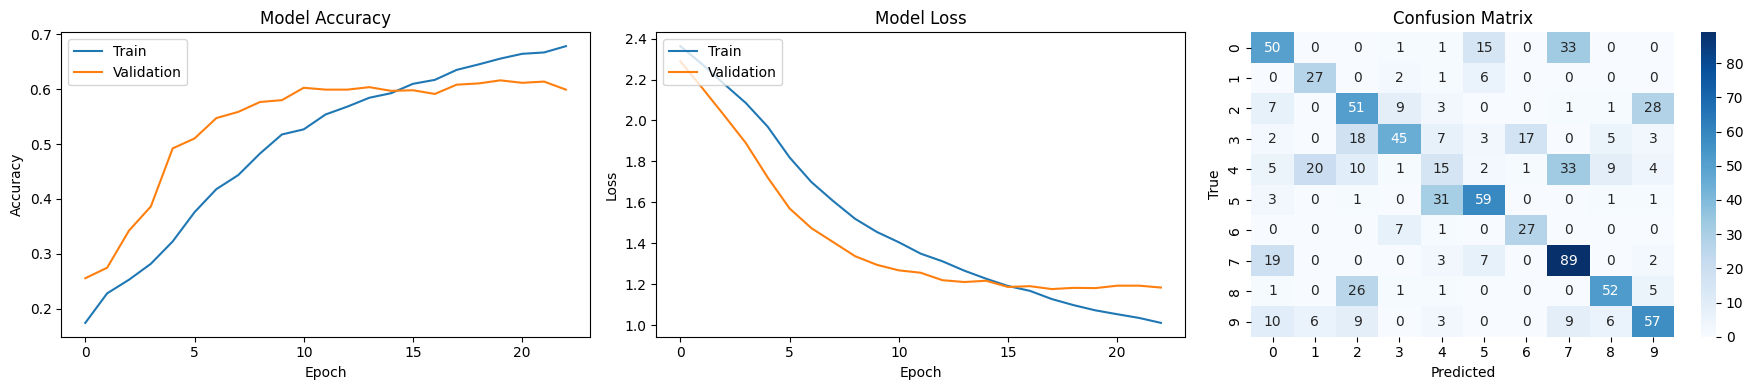

Fold 1 Test Accuracy: 0.5407

Training fold 2...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.1413 - loss: 2.3962 - val_accuracy: 0.1816 - val_loss: 2.3591
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2342 - loss: 2.3110 - val_accuracy: 0.1665 - val_loss: 2.2787
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2742 - loss: 2.2048 - val_accuracy: 0.1795 - val_loss: 2.2171
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3211 - loss: 2.0853 - val_accuracy: 0.1924 - val_loss: 2.1344
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.3626 - loss: 1.9584 - val_accuracy: 0.2573 - val_loss: 2.0132
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.3902 - loss: 1.8059 - val_accuracy: 0.2530 - val_loss: 1.9434
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.4316 - loss: 1.6970 - val_accuracy: 0.2768 - val_loss: 1.9029
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.4536 - loss: 1.6214 - val_accuracy: 0.2973 - val_loss: 1

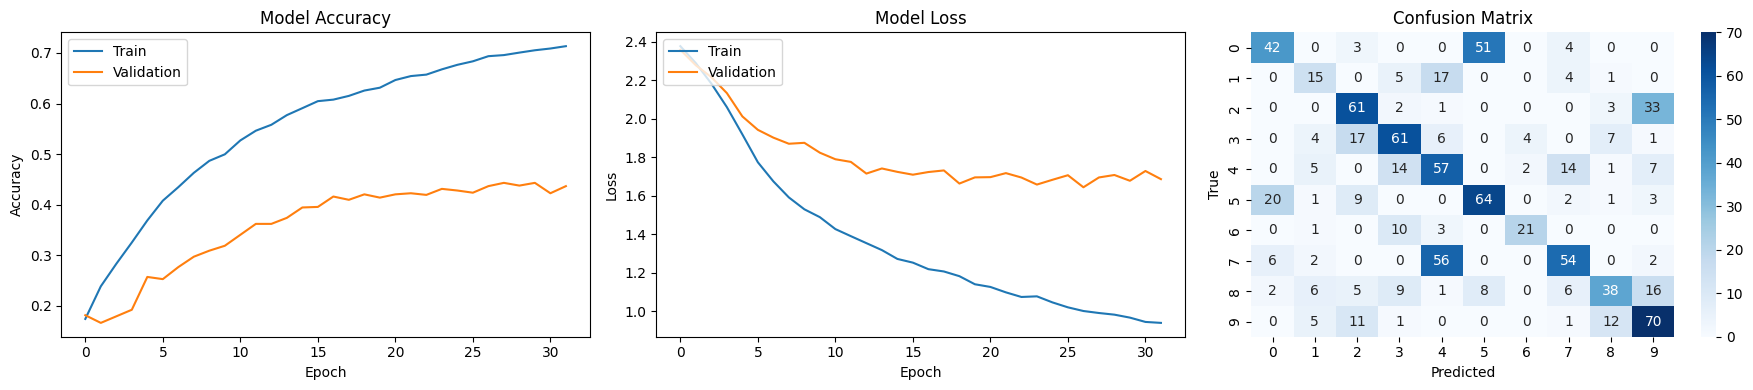

Fold 2 Test Accuracy: 0.5439

Training fold 3...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.1643 - loss: 2.3812 - val_accuracy: 0.1980 - val_loss: 2.3252
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.2304 - loss: 2.2950 - val_accuracy: 0.1929 - val_loss: 2.2367
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.2577 - loss: 2.1823 - val_accuracy: 0.2465 - val_loss: 2.1333
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.2883 - loss: 2.0683 - val_accuracy: 0.2949 - val_loss: 2.0354
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.3340 - loss: 1.9534 - val_accuracy: 0.3081 - val_loss: 1.9639
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3798 - loss: 1.8522 - val_accuracy: 0.3515 - val_loss: 1.8863
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4191 - loss: 1.7364 - val_accuracy: 0.3838 - val_loss: 1.8001
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.4451 - loss: 1.6622 - val_accuracy: 0.4192 - val_loss: 1

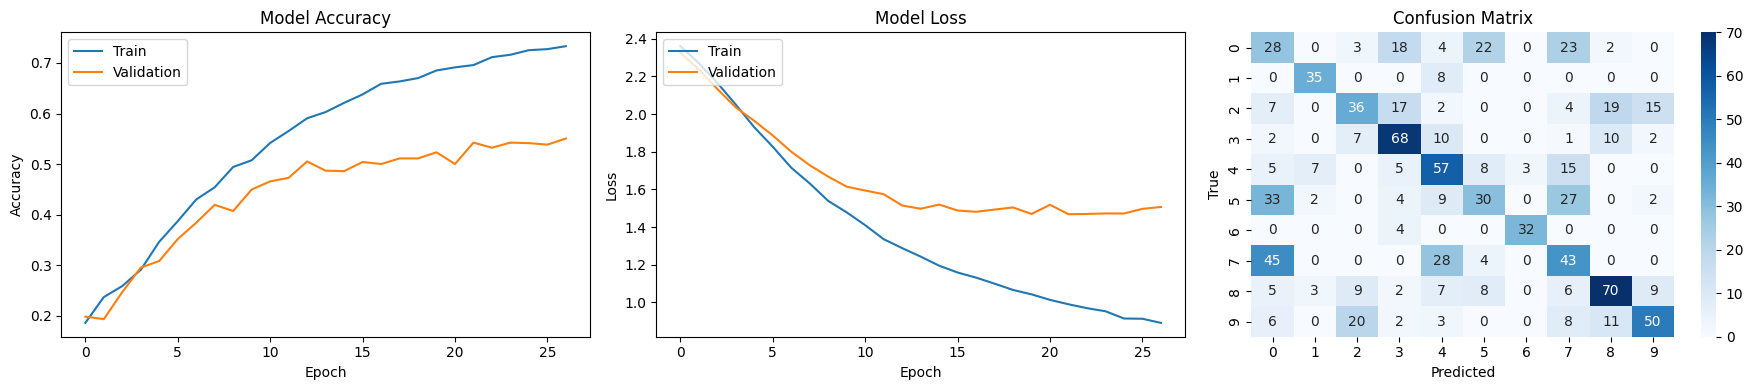

Fold 3 Test Accuracy: 0.4854

Training fold 4...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1506 - loss: 2.3851 - val_accuracy: 0.2115 - val_loss: 2.3206
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2404 - loss: 2.2878 - val_accuracy: 0.2212 - val_loss: 2.2287
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2564 - loss: 2.1857 - val_accuracy: 0.2425 - val_loss: 2.1450
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3020 - loss: 2.0636 - val_accuracy: 0.2831 - val_loss: 2.0614
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3438 - loss: 1.9306 - val_accuracy: 0.3301 - val_loss: 1.9482
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3975 - loss: 1.7913 - val_accuracy: 0.3611 - val_loss: 1.8421
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4448 - loss: 1.6479 - val_accuracy: 0.3889 - val_loss: 1.7816
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4654 - loss: 1.5624 - val_accuracy: 0.3932 - val_loss: 1

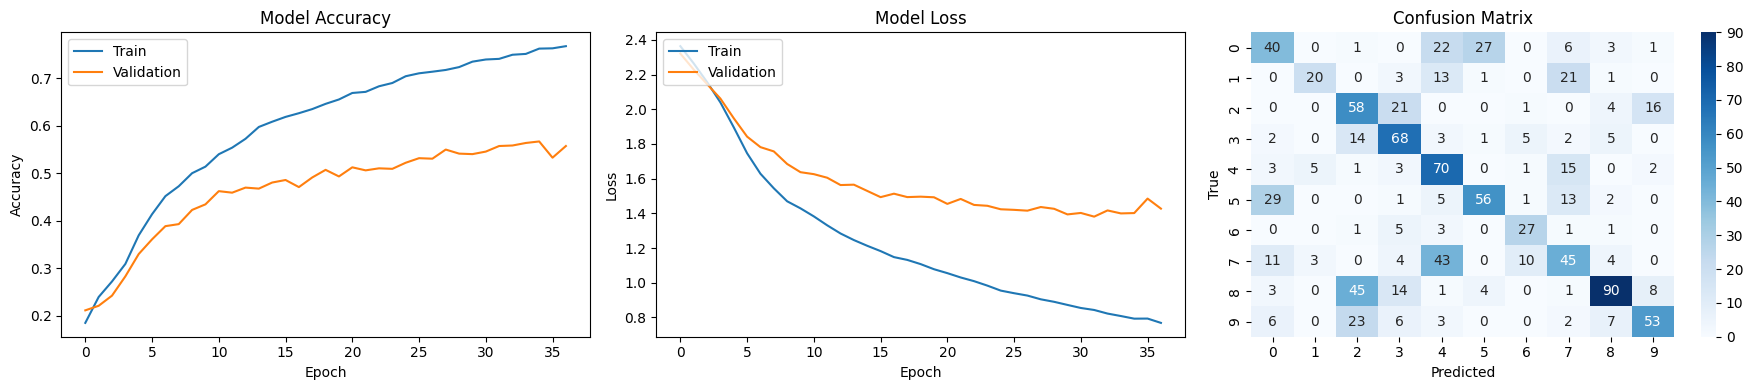

Fold 4 Test Accuracy: 0.5323

Training fold 5...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.1642 - loss: 2.3775 - val_accuracy: 0.2090 - val_loss: 2.3071
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2160 - loss: 2.2759 - val_accuracy: 0.2515 - val_loss: 2.2216
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2589 - loss: 2.1728 - val_accuracy: 0.2600 - val_loss: 2.1404
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2797 - loss: 2.0815 - val_accuracy: 0.2795 - val_loss: 2.0729
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3184 - loss: 1.9944 - val_accuracy: 0.3013 - val_loss: 1.9915
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3521 - loss: 1.8883 - val_accuracy: 0.3706 - val_loss: 1.8767
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4207 - loss: 1.7672 - val_accuracy: 0.4156 - val_loss: 1.7674
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4668 - loss: 1.6266 - val_accuracy: 0.4629 - val_loss: 1

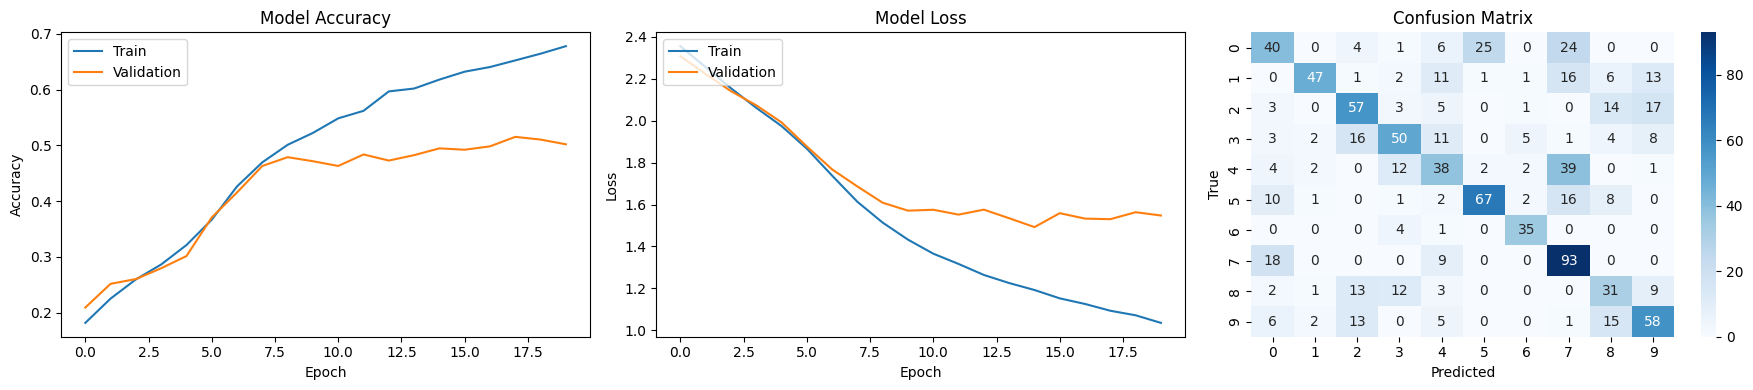

Fold 5 Test Accuracy: 0.5513

Training fold 6...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.1549 - loss: 2.3854 - val_accuracy: 0.2232 - val_loss: 2.3032
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2185 - loss: 2.2979 - val_accuracy: 0.2279 - val_loss: 2.1949
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2530 - loss: 2.1899 - val_accuracy: 0.2399 - val_loss: 2.0956
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2932 - loss: 2.0817 - val_accuracy: 0.2542 - val_loss: 1.9921
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3330 - loss: 1.9592 - val_accuracy: 0.3174 - val_loss: 1.8620
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4003 - loss: 1.8000 - val_accuracy: 0.3938 - val_loss: 1.7249
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4238 - loss: 1.6725 - val_accuracy: 0.4451 - val_loss: 1.6441
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4658 - loss: 1.5685 - val_accuracy: 0.4893 - val_loss: 1

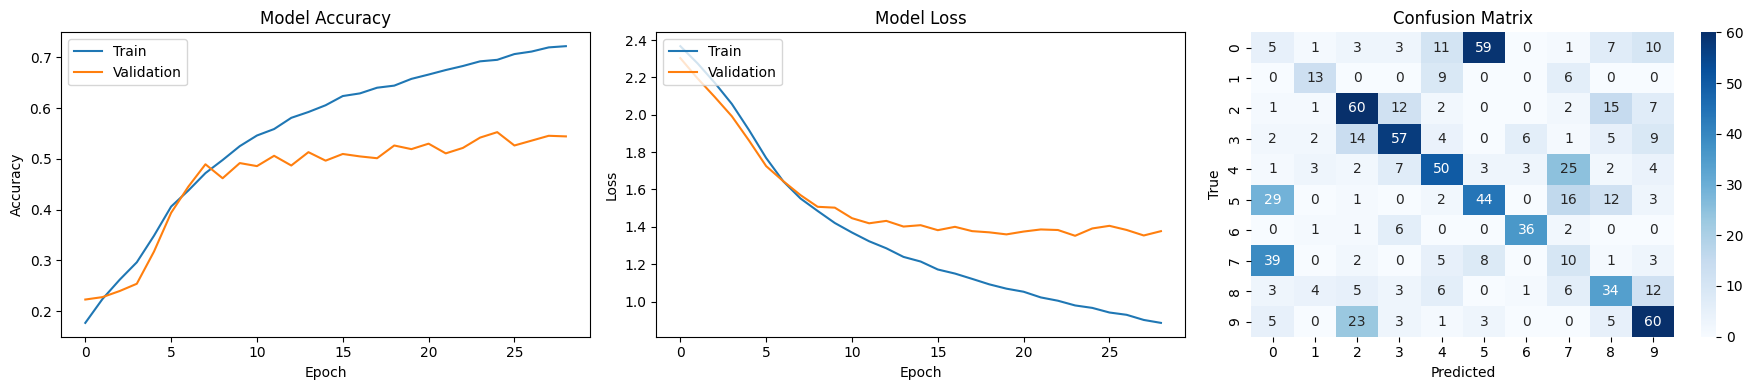

Fold 6 Test Accuracy: 0.4484

Training fold 7...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.1351 - loss: 2.3902 - val_accuracy: 0.2060 - val_loss: 2.3194
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2451 - loss: 2.2912 - val_accuracy: 0.2419 - val_loss: 2.1981
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2640 - loss: 2.1814 - val_accuracy: 0.3027 - val_loss: 2.0809
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3088 - loss: 2.0530 - val_accuracy: 0.3524 - val_loss: 1.9569
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3595 - loss: 1.9088 - val_accuracy: 0.3524 - val_loss: 1.8543
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4080 - loss: 1.7556 - val_accuracy: 0.3734 - val_loss: 1.7861
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4310 - loss: 1.6413 - val_accuracy: 0.3921 - val_loss: 1.7407
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4633 - loss: 1.5704 - val_accuracy: 0.4268 - val_loss: 1

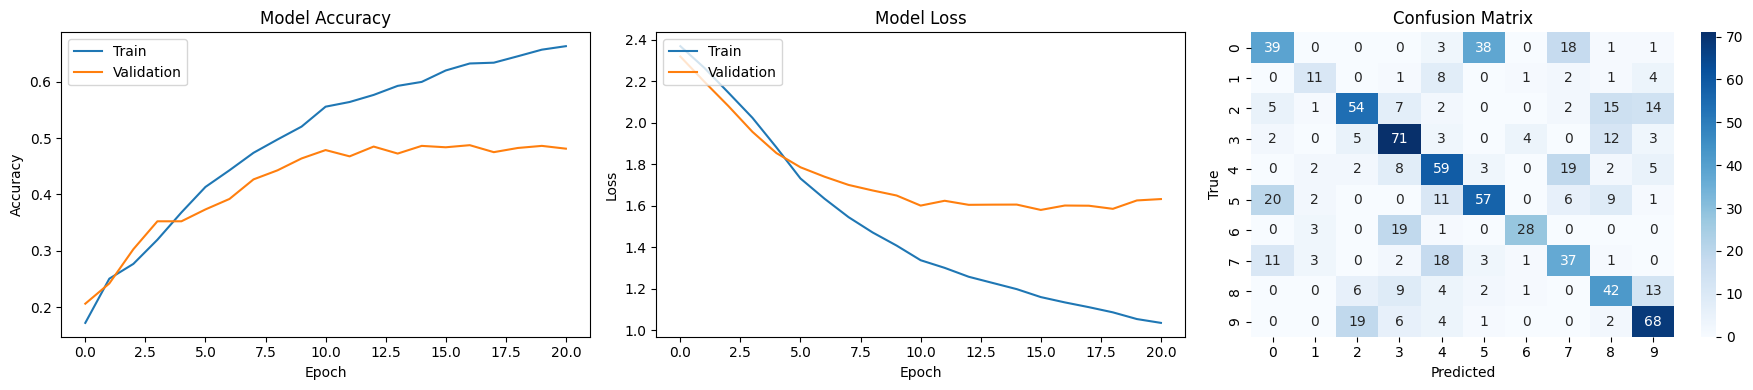

Fold 7 Test Accuracy: 0.5561

Training fold 8...


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.1455 - loss: 2.3848 - val_accuracy: 0.1765 - val_loss: 2.3466
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2050 - loss: 2.2873 - val_accuracy: 0.1998 - val_loss: 2.2728
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2572 - loss: 2.1656 - val_accuracy: 0.2096 - val_loss: 2.2030
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2980 - loss: 2.0617 - val_accuracy: 0.2659 - val_loss: 2.1280
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.3351 - loss: 1.9544 - val_accuracy: 0.3076 - val_loss: 2.0229
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3834 - loss: 1.8294 - val_accuracy: 0.3554 - val_loss: 1.9189
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4333 - loss: 1.7184 - val_accuracy: 0.3971 - val_loss: 1.8767
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4526 - loss: 1.6344 - val_accuracy: 0.4289 - 

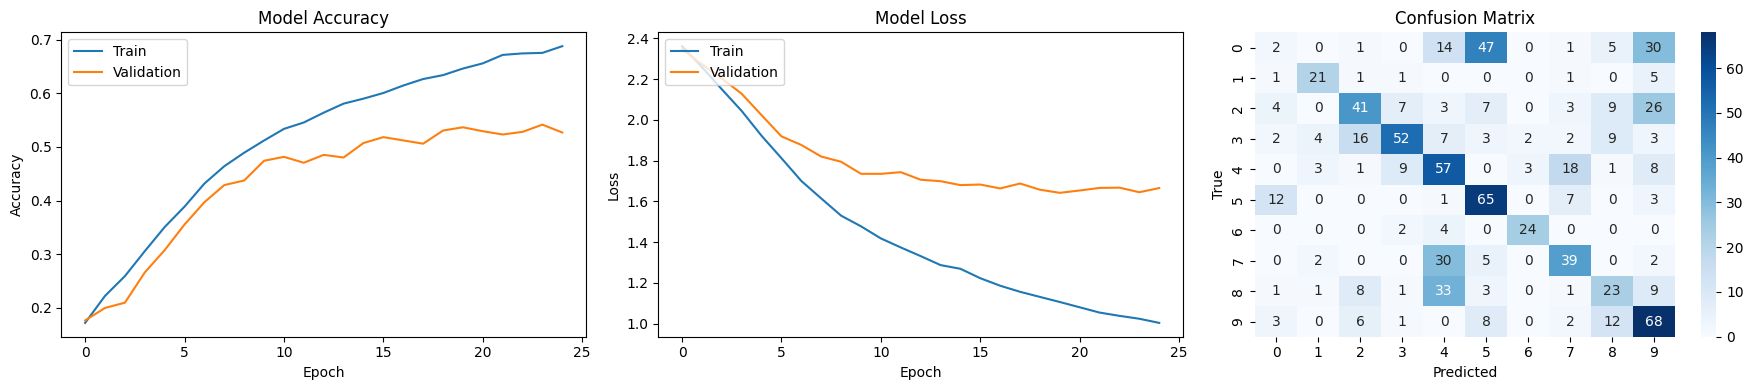

Fold 8 Test Accuracy: 0.4864

Training fold 9...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.1301 - loss: 2.3972 - val_accuracy: 0.2222 - val_loss: 2.3245
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2153 - loss: 2.3134 - val_accuracy: 0.2497 - val_loss: 2.2086
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2466 - loss: 2.2021 - val_accuracy: 0.2963 - val_loss: 2.0709
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2968 - loss: 2.0763 - val_accuracy: 0.3704 - val_loss: 1.8515
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.3533 - loss: 1.8764 - val_accuracy: 0.4397 - val_loss: 1.6858
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3959 - loss: 1.7378 - val_accuracy: 0.4743 - val_loss: 1.6014
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4221 - loss: 1.6450 - val_accuracy: 0.4994 - val_loss: 1.5606
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4558 - loss: 1.5677 - val_accuracy: 0.5233 - val_loss: 1

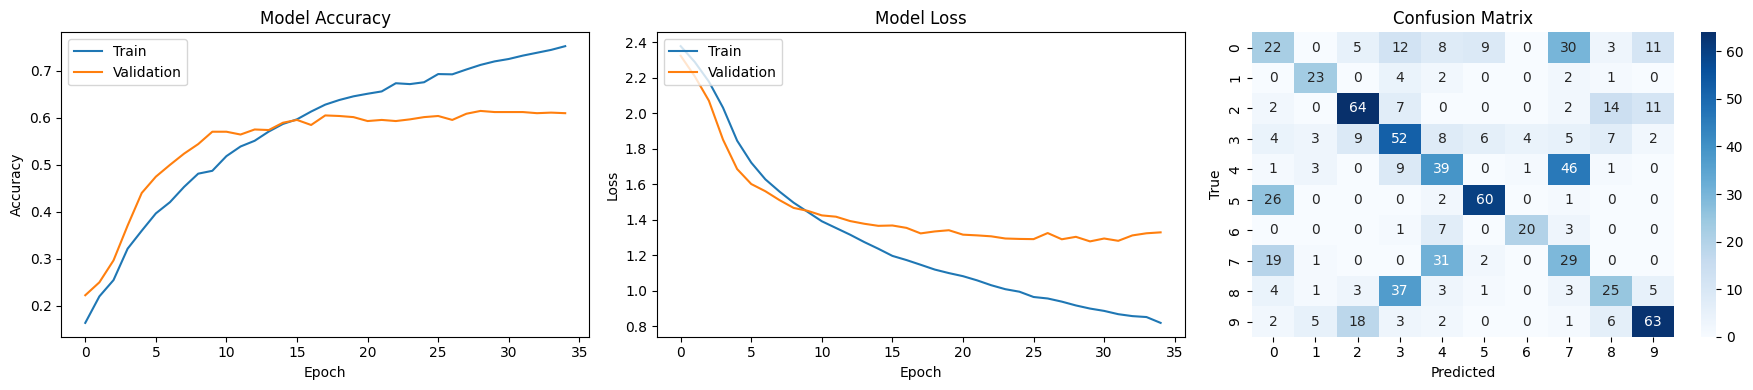

Fold 9 Test Accuracy: 0.4865

Training fold 10...
Epoch 1/50


c:\Users\Utilizador\Desktop\FCUP3\ML2Trab\.conda\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.1282 - loss: 2.3937 - val_accuracy: 0.1810 - val_loss: 2.3454
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2192 - loss: 2.2943 - val_accuracy: 0.2428 - val_loss: 2.2674
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2601 - loss: 2.1900 - val_accuracy: 0.2944 - val_loss: 2.1783
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3031 - loss: 2.0890 - val_accuracy: 0.3425 - val_loss: 2.0759
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3533 - loss: 1.9630 - val_accuracy: 0.3906 - val_loss: 1.8763
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.3930 - loss: 1.8060 - val_accuracy: 0.3562 - val_loss: 1.7900
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4192 - loss: 1.7077 - val_accuracy: 0.4158 - val_loss: 1.6817
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.4575 - loss: 1.5874 - val_accuracy: 0.3906 - val_loss: 1

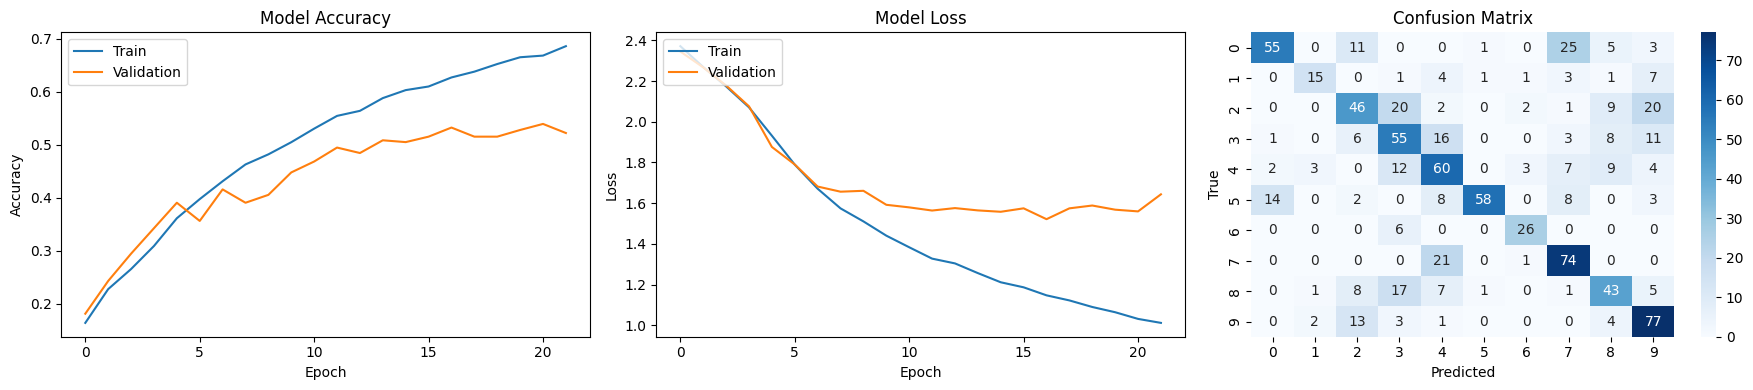

Fold 10 Test Accuracy: 0.6081

Average Accuracy across 10 folds: 52.3904%
Standard Deviation: 4.4303%


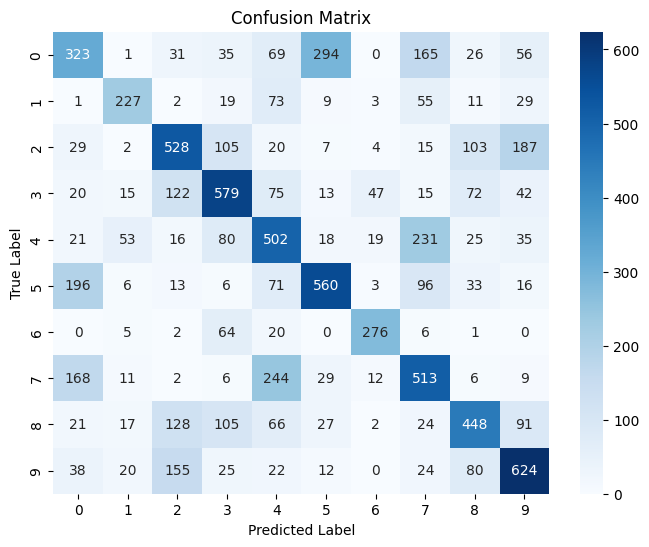

In [ ]:
num_folds = 10
fold_accuracies = []
early_stoppings=[]
for i in range(num_folds):
    early_stoppings.append(EarlyStopping(
        monitor='val_loss',  # Metric to monitor; commonly 'val_loss' or 'val_accuracy'
        patience=5 ,          # Number of epochs to wait after no improvement
        restore_best_weights=True,  # Restores model weights to the best epoch with the lowest monitored metric
        verbose=1            # Print messages when early stopping is triggered
    ))
    
y_test_multiclasses = []
predicted_labels_rnns = []
class_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
for i in range(num_folds):
    # Define the test and validation indices
    test_idx = i
    val_idx = (i + 1) % num_folds
    
    # Split the data accordingly
    X_test = X_folds[test_idx]
    y_test = y_folds[test_idx]
    X_val = X_folds[val_idx]
    y_val = y_folds[val_idx]

    # Combine the remaining folds for training
    X_train = np.concatenate([X_folds[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)
    y_train = np.concatenate([y_folds[j] for j in range(num_folds) if j != test_idx and j != val_idx], axis=0)

    # Create a new model instance for each fold
    model = create_bidirectional_lstm_model()
    
    # Train the model
    print(f"\nTraining fold {i + 1}...")
    history=model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stoppings[i]])
    model.save(f"model_fold{i}.keras")

    predictions_rnn = model.predict(X_test)
    predicted_labels_rnn = np.argmax(predictions_rnn, axis=1)

    y_test_multiclass = np.argmax(y_test, axis=1)
    
    if i==0:
        y_test_multiclasses = y_test_multiclass
        predicted_labels_rnns = predicted_labels_rnn
    else:
        y_test_multiclasses = np.concatenate((y_test_multiclasses, y_test_multiclass))
        predicted_labels_rnns = np.concatenate((predicted_labels_rnns, predicted_labels_rnn))

    plot_graphs(history, y_test_multiclass, predicted_labels_rnn, class_labels=class_labels)

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Fold {i + 1} Test Accuracy: {test_acc:.4f}")
    
    # Save the accuracy for later analysis
    fold_accuracies.append(test_acc)

average_accuracy = np.mean(fold_accuracies)
print(f"\nAverage Accuracy across {num_folds} folds: {average_accuracy*100:.4f}%")
print(f"Standard Deviation: {np.std(fold_accuracies)*100:.4f}%")

# Print average accuracy across all folds
cm = confusion_matrix(y_test_multiclasses, predicted_labels_rnns)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()